In [1]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_provider import IBMProvider

In [2]:
provider = IBMProvider()

# backends = provider.backends(simulator=False, operational=True)

# # choose IBMQ backend
# backend = least_busy(backends)

backend = provider.get_backend("ibmq_belem")

backend.name

'ibmq_belem'

In [3]:
from qiskit.utils import algorithm_globals
from qiskit.algorithms.minimum_eigensolvers import QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
    SolutionSample,
    OptimizationResultStatus,
)
from qiskit_optimization import QuadraticProgram
from qiskit.visualization import plot_histogram
from typing import List, Tuple
import numpy as np

In [4]:
def name_nodes(qubo, plants_counts, field_count, years_count):
    # Create a cube
    for plant in range(plants_count):
        for field in range(field_count):
            for year in range(years_count):
                name = f"x_p{plant}_l{field}_t{year}"
                qubo.binary_var(name)
                
                # In the form: 
                # qubo.binary_var("x_p1_l1_t2")

In [41]:
qubo = QuadraticProgram()

# Parameters:     
# soil quality - what's the nitrogen availability 
# in the soil (a grade between 0 and 1)
# Note: In the beginning all the parameters are ideal 
soil_quality = 1
# qubo.binary_var("soil_quality")

# Per unit field in dollars
fertilizer_price = 10.55
# qubo.binary_var("fertilizer_price")

# A unit area of a field
field_area = 1
# qubo.binary_var("field_area")

# Environment factor (?) - a grade between 0 and 1
env = 1
# qubo.binary_var("env")

# Nodes in the 3D cube: checkout the documentation
# Number of crops type
plants_count = 2
# Number of available field in which the crops should rotate
fields_count = 2
# Number of years/seasons for rotating the crops
years_count = 2

name_nodes(qubo, plants_count, fields_count, years_count)

qubo.maximize(linear=[1, 3, 4, -2, 3, 4, -1, 1], quadratic={
    (0, 1): 1,
    (1, 2):2, 
    (2, 3):1
})
#qubo.linear_constraint(
print(qubo.prettyprint())

Problem name: 

Maximize
  x_p0_l0_t0*x_p0_l0_t1 + 2*x_p0_l0_t1*x_p0_l1_t0 + x_p0_l1_t0*x_p0_l1_t1
  + x_p0_l0_t0 + 3*x_p0_l0_t1 + 4*x_p0_l1_t0 - 2*x_p0_l1_t1 + 3*x_p1_l0_t0
  + 4*x_p1_l0_t1 - x_p1_l1_t0 + x_p1_l1_t1

Subject to
  No constraints

  Binary variables (8)
    x_p0_l0_t0 x_p0_l0_t1 x_p0_l1_t0 x_p0_l1_t1 x_p1_l0_t0 x_p1_l0_t1 x_p1_l1_t0
    x_p1_l1_t1



In [42]:
op, offset = qubo.to_ising()
print("offset: {}".format(offset))
print("operator:")
print(op)

offset: -7.5
operator:
0.75 * IIIIIIIZ
+ 2.25 * IIIIIIZI
+ 2.75 * IIIIIZII
- 0.75 * IIIIZIII
+ 1.5 * IIIZIIII
+ 2.0 * IIZIIIII
- 0.5 * IZIIIIII
+ 0.5 * ZIIIIIII
- 0.25 * IIIIIIZZ
- 0.5 * IIIIIZZI
- 0.25 * IIIIZZII


In [43]:
## initializing the MinimumEigensolver we want to use
algorithm_globals.random_seed = 10598
qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA())#, initial_point=[0.0, 0.0])
exact_mes = NumPyMinimumEigensolver()

In [44]:
qaoa = MinimumEigenOptimizer(qaoa_mes)  # using QAOA
exact = MinimumEigenOptimizer(exact_mes)  # using the exact classical numpy minimum eigen solver

In [45]:
exact_result = exact.solve(qubo)
print(exact_result.prettyprint())

objective function value: 19.0
variable values: x_p0_l0_t0=1.0, x_p0_l0_t1=1.0, x_p0_l1_t0=1.0, x_p0_l1_t1=0.0, x_p1_l0_t0=1.0, x_p1_l0_t1=1.0, x_p1_l1_t0=0.0, x_p1_l1_t1=1.0
status: SUCCESS


In [46]:
qaoa_result = qaoa.solve(qubo)
print(qaoa_result.prettyprint())

objective function value: 19.0
variable values: x_p0_l0_t0=1.0, x_p0_l0_t1=1.0, x_p0_l1_t0=1.0, x_p0_l1_t1=0.0, x_p1_l0_t0=1.0, x_p1_l0_t1=1.0, x_p1_l1_t0=0.0, x_p1_l1_t1=1.0
status: SUCCESS


In [47]:
# print("variable order:", [var.name for var in qaoa_result.variables])
# for s in qaoa_result.samples:
#     print(s)

In [48]:
def get_filtered_samples(
    samples: List[SolutionSample],
    threshold: float = 0,
    allowed_status: Tuple[OptimizationResultStatus] = (OptimizationResultStatus.SUCCESS,),
):
    res = []
    for s in samples:
        if s.status in allowed_status and s.probability > threshold:
            res.append(s)

    return res

In [50]:
# filtered_samples = get_filtered_samples(
#     qaoa_result.samples, threshold=0.005, allowed_status=(OptimizationResultStatus.SUCCESS,)
# )
# for s in filtered_samples:
#     print(s)

In [51]:
fvals = [s.fval for s in qaoa_result.samples]
probabilities = [s.probability for s in qaoa_result.samples]

In [52]:
samples_for_plot = {
    " ".join(f"{qaoa_result.variables[i].name}={int(v)}" for i, v in enumerate(s.x)): s.probability
    for s in filtered_samples
}
samples_for_plot

{'x_p0_l0_t0=1 x_p0_l0_t1=1 x_p0_l1_t0=1 x_p0_l1_t1=0 x_p1_l0_t0=1 x_p1_l0_t1=1 x_p1_l1_t0=0 x_p1_l1_t1=1': 0.2124240224248315,
 'x_p0_l0_t0=1 x_p0_l0_t1=1 x_p0_l1_t0=1 x_p0_l1_t1=0 x_p1_l0_t0=1 x_p1_l0_t1=1 x_p1_l1_t0=0 x_p1_l1_t1=0': 0.1055112380534506,
 'x_p0_l0_t0=1 x_p0_l0_t1=1 x_p0_l1_t0=1 x_p0_l1_t1=1 x_p1_l0_t0=1 x_p1_l0_t1=1 x_p1_l1_t0=0 x_p1_l1_t1=1': 0.0724403305393964,
 'x_p0_l0_t0=1 x_p0_l0_t1=1 x_p0_l1_t0=1 x_p0_l1_t1=0 x_p1_l0_t0=1 x_p1_l0_t1=1 x_p1_l1_t0=1 x_p1_l1_t1=1': 0.1055112380534506,
 'x_p0_l0_t0=1 x_p0_l0_t1=1 x_p0_l1_t0=1 x_p0_l1_t1=1 x_p1_l0_t0=1 x_p1_l0_t1=1 x_p1_l1_t0=0 x_p1_l1_t1=0': 0.0359811892881256,
 'x_p0_l0_t0=1 x_p0_l0_t1=1 x_p0_l1_t0=1 x_p0_l1_t1=0 x_p1_l0_t0=1 x_p1_l0_t1=1 x_p1_l1_t0=1 x_p1_l1_t1=0': 0.0524075442527284,
 'x_p0_l0_t0=0 x_p0_l0_t1=1 x_p0_l1_t0=1 x_p0_l1_t1=0 x_p1_l0_t0=1 x_p1_l0_t1=1 x_p1_l1_t0=0 x_p1_l1_t1=1': 0.0730856230081007,
 'x_p0_l0_t0=1 x_p0_l0_t1=1 x_p0_l1_t0=1 x_p0_l1_t1=1 x_p1_l0_t0=1 x_p1_l0_t1=1 x_p1_l1_t0=1 x_p1_l1_t1=

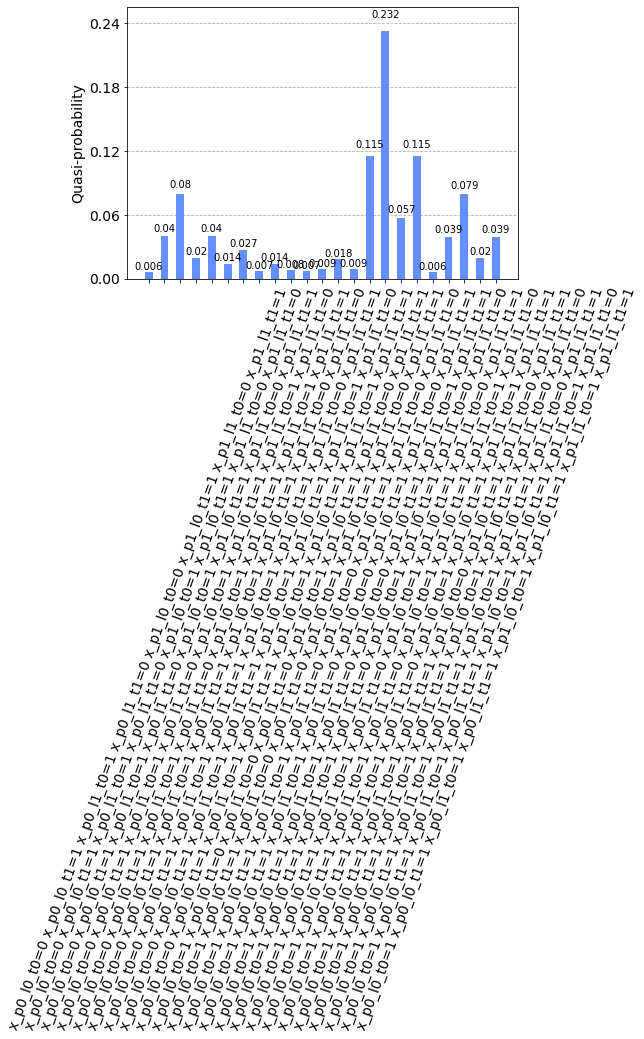

In [53]:
plot_histogram(samples_for_plot)